# Imports

In [2]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import cv2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [3]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Space invaders environment

### Parallel env uniform random agent template

In [90]:
# function for a single uniform random experiment
def run_uniform(parallel_env, episode_count, gamma=0.999, render_mode="rgb_array", record_video=False, video_prefix=""):
    """
    Runs the parallel environment with the given hyperparameters and parameters.

    Args:
        parallel_env (parallel_api.ParallelEnv): Parallel environment to run.
        episode_count (int): Number of episodes to run the environment for.
        gamma (float): Discount factor for calculating discounted rewards.
        render_mode (str): Rendering mode for the environment.
        record_video (bool): Whether to record videos of the environment.
        video_prefix (str): Prefix for the video filenames.

    Returns:
        ep_rewards (dict): Dictionary of episode rewards for each agent.
        ep_rewards_d (dict): Dictionary of discounted episode rewards for each agent.
        ep_steps (np.ndarray): Array of episode steps for each episode.
        ep_rewards_all (np.ndarray): Array of episode rewards for all agents for each episode.
        ep_rewards_d_all (np.ndarray): Array of discounted episode rewards for all agents for each episode.
    """
 
    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        agent_states = parallel_env.reset(seed=seed)
        first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
        assert np.array_equal(first_0_state, second_0_state)

        terminations = [False]
        truncations = [False]

        if render_mode == "human":
            clock = pygame.time.Clock()

        video_writer = None
        if record_video and ep % 100 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{ep}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)

        # Run the environment until all agents have terminated or truncated
        while not all(terminations) and not all(truncations):
            if render_mode == "human":
                clock.tick(parallel_env.metadata["render_fps"])
            
            # Take an action for each agent
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
            
            # Step the environment
            agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
            assert np.array_equal(agent_states['first_0'], agent_states['second_0'])
            
            terminations = [terminations[a] for a in terminations]
            truncations = [truncations[a] for a in truncations]
            
            for agent in parallel_env.possible_agents:
                ep_rewards[agent][ep] += rewards[agent]
                ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])
            
            ep_rewards_all[ep] += sum(rewards.values())
            ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
            
            ep_steps[ep] += 1
            ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

            if record_video:
                frame = parallel_env.render()
                if record_video and ep % 100 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

        if video_writer is not None:
            video_writer.release()
                
    # Return the different rewards
    return ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


In [91]:
#hyperparameters
experiment_count = 5
episode_count = 100
gamma = 0.999 #discount factor
render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]

record_video = True #record video of the experiment every 100 episodes
game_name = "SpaceInvaders-v2" #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_uni = np.zeros((experiment_count, episode_count))
ep_steps_d_uni = np.zeros((experiment_count, episode_count))
ep_rewards_all_uni = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_uni = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    print("Experiment {}".format(i))
    #create the parallel environment
    parallel_env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    
    #run the experiment and store the rewards in the arrays
    ep_rewards_uni_all, ep_rewards_d_uni_all, ep_steps_uni[i], ep_steps_d_uni[i], ep_rewards_all_uni[i], ep_rewards_d_all_uni[i] = run_uniform(parallel_env, episode_count, gamma, render_mode, record_video, video_prefix = f'videos/{game_name}_ex{i}_')
    ep_rewards_uni['first_0'][i] = ep_rewards_uni_all['first_0']
    ep_rewards_uni['second_0'][i] = ep_rewards_uni_all['second_0']
    ep_rewards_d_uni['first_0'][i] = ep_rewards_d_uni_all['first_0']
    ep_rewards_d_uni['second_0'][i] = ep_rewards_d_uni_all['second_0']
    
    #close the parallel environment
    parallel_env.close()


Experiment 0


  0%|          | 0/100 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__uni_episode_0_gamma_0.999.avi


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


In [6]:
#print the rewards obtained in the arrays
print("Total rewards for each agent:")
print(ep_rewards_uni)
print("Total discounted rewards for each agent:")
print(ep_rewards_d_uni)
print("Total steps for all agents:")
print(ep_steps_uni)
print("Total discounted steps for all agents:")
print(ep_steps_d_uni)
print("Total reward for all agents:")
print(ep_rewards_all_uni)
print("Total discounted reward for all agents:")
print(ep_rewards_d_all_uni)

# High scores
# Print the highest rewards for each agent over all episodes in all experiments
print("High scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_uni[agent], axis=1)))
# Print the highest discounted rewards for each agent over all episodes in all experiments
print("High discounted scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_d_uni[agent], axis=1)))
# Print the highest steps for all agent over all episodes in all experiments
print("Highest steps:")
print(np.max(np.max(ep_steps_uni, axis=1)))
# Print the highest discounted steps for all agent over all episodes in all experiments
print("Highest discounted steps:")
print(np.max(np.max(ep_steps_d_uni, axis=1)))
# Print the highest rewards for all agent over all episodes in all experiments
print("Highest rewards:")
print(np.max(np.max(ep_rewards_all_uni, axis=1)))
# Print the highest discounted rewards for all agent over all episodes in all experiments
print("Highest discounted rewards:")
print(np.max(np.max(ep_rewards_d_all_uni, axis=1)))



Total rewards for each agent:
{'first_0': array([[ 65., 615., 520., 385., 215., 550., 810., 450., 510., 585., 365.,
        555., 130., 420., 775., 415., 445., 480., 220., 535., 420., 785.,
        215., 350., 320., 580., 485., 220., 305., 230., 520., 230., 430.,
        435., 435., 525., 230., 220., 215., 455., 110., 420., 425., 535.,
        320., 205., 465., 295., 620., 600., 635., 510., 340., 280., 435.,
        250., 325., 510., 705., 290., 460., 295., 360., 290., 420., 385.,
        620., 715., 880., 260., 250., 705., 480., 310., 405., 255., 430.,
        350., 540., 510., 460., 410., 215., 650., 485., 595., 450., 350.,
        265., 390., 395., 230., 685., 655., 435., 475., 230., 280., 425.,
        250.]]), 'second_0': array([[625.,  50., 300., 670., 605., 550., 415., 525., 290., 355., 695.,
        335., 780., 455., 555., 535., 275., 220., 405., 220., 445., 415.,
        630., 580., 510., 555., 745., 465., 535., 455., 540., 415., 235.,
        275., 255., 305., 420., 450., 430

### Calculations and plotting

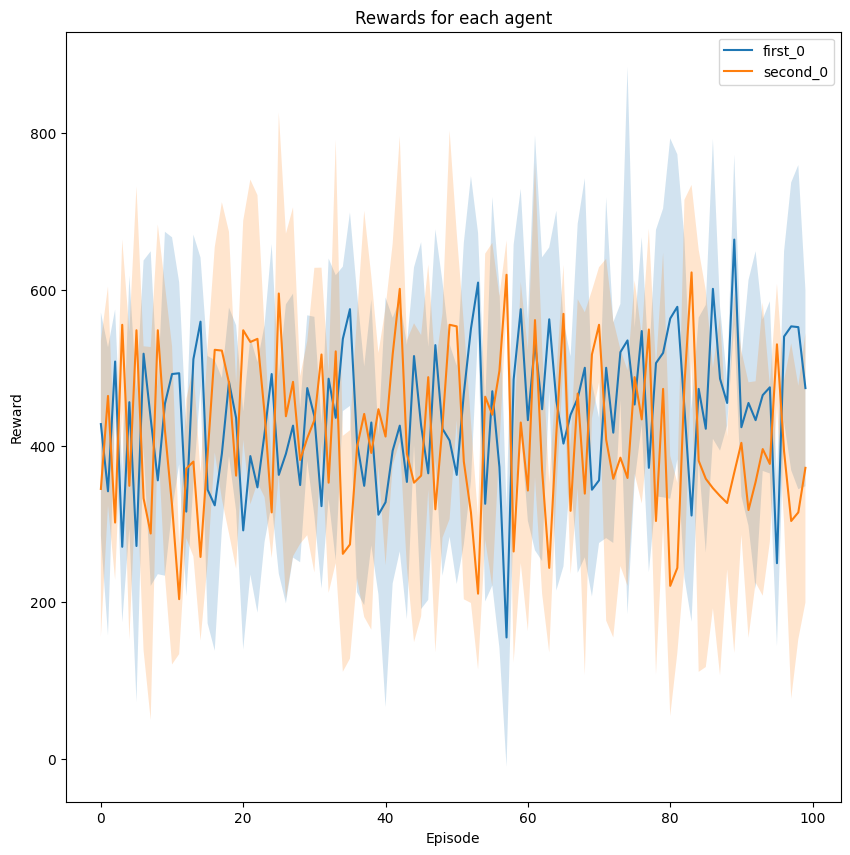

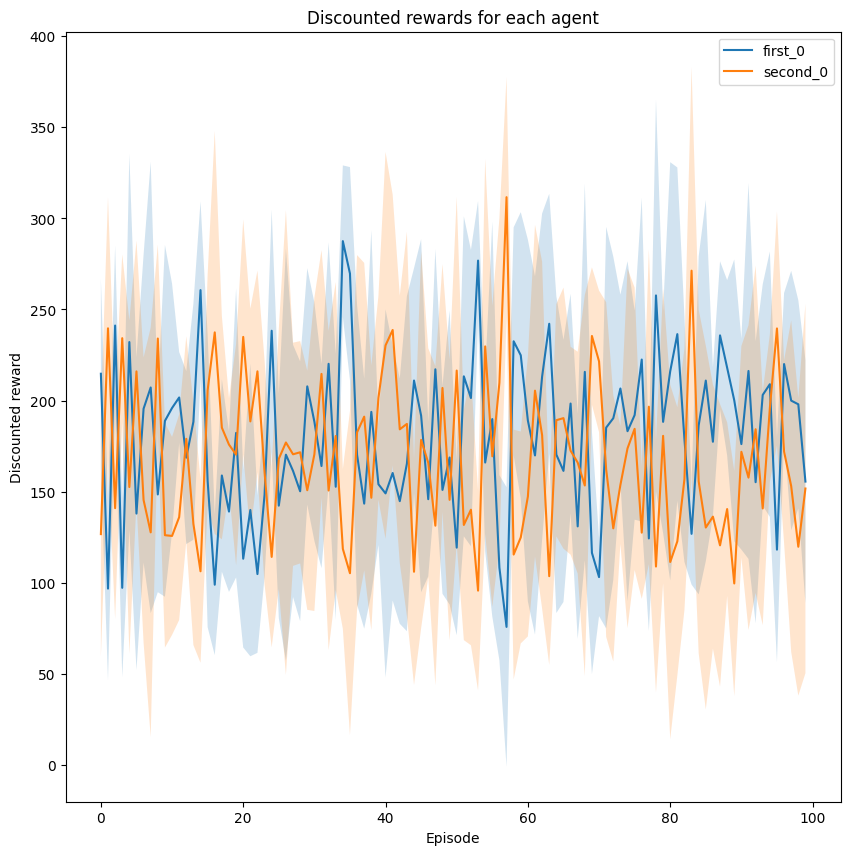

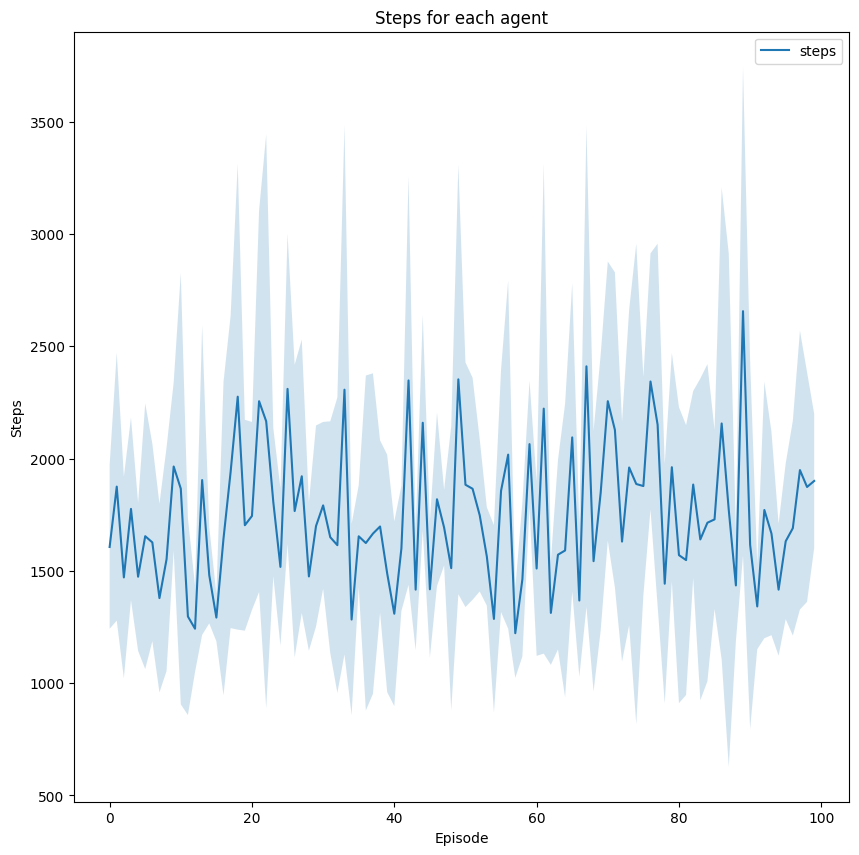

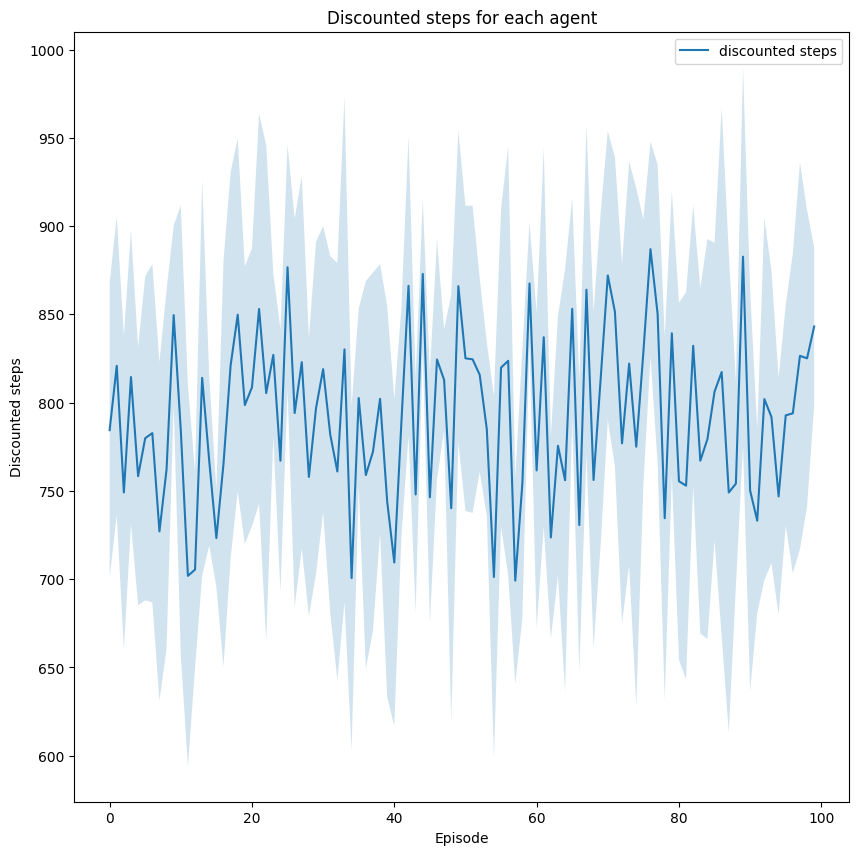

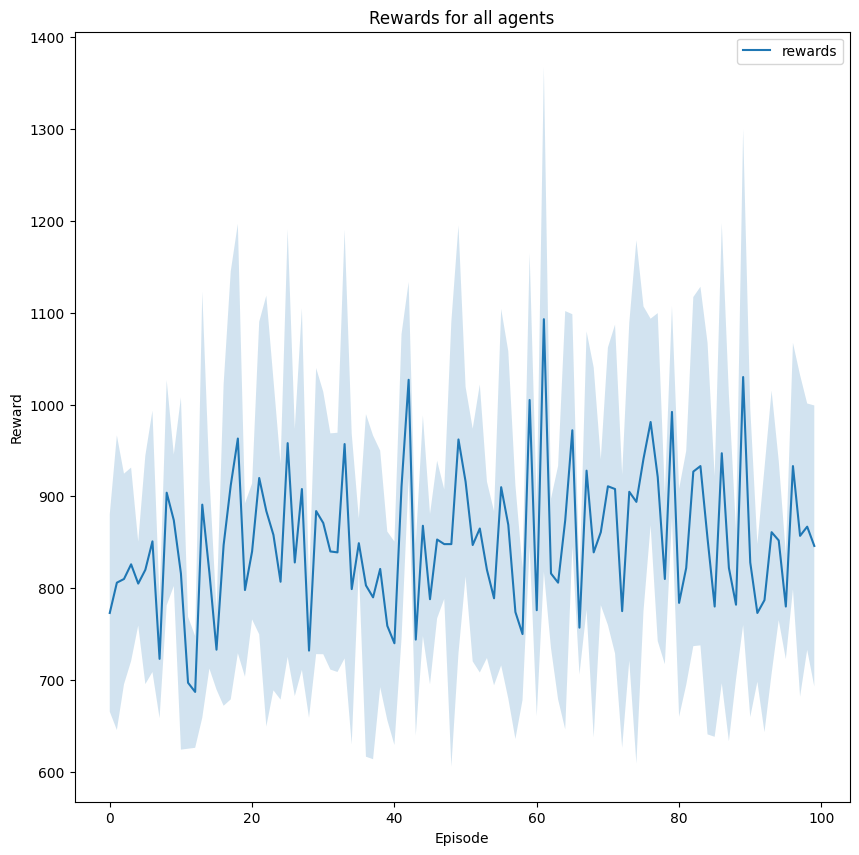

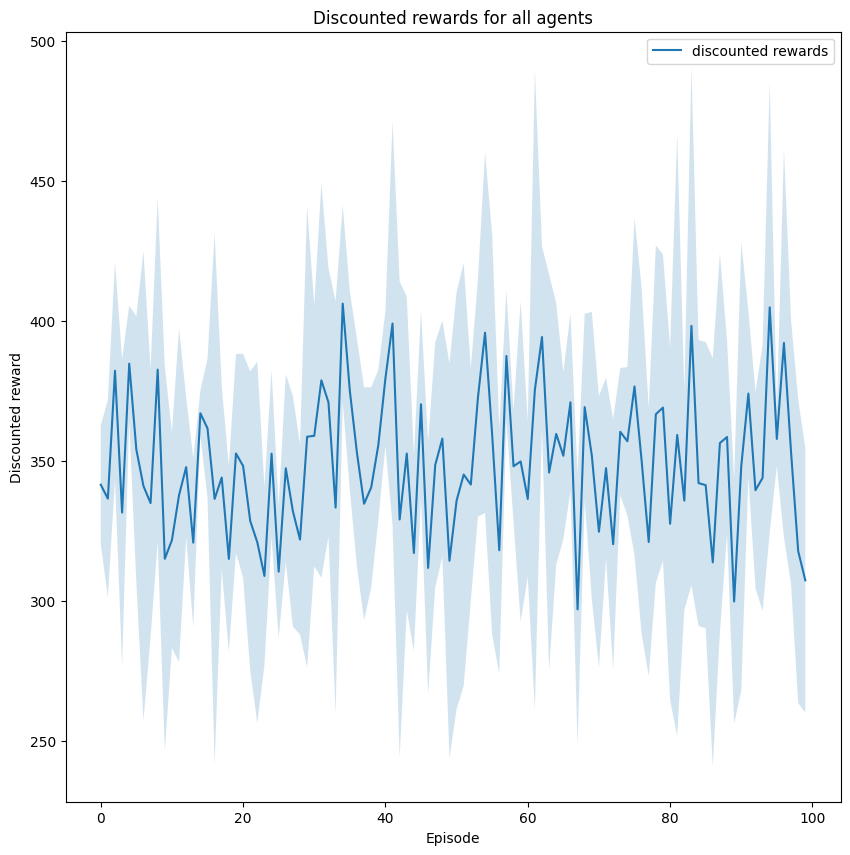

In [54]:
# Caluculate the mean and standard deviation of the rewards for each agent and all agents for each experiment
ep_rewards_uni_mean = {agent: np.mean(ep_rewards_uni[agent], axis=0) for agent in agent_names}
ep_rewards_uni_std = {agent: np.std(ep_rewards_uni[agent], axis=0) for agent in agent_names}
ep_rewards_d_uni_mean = {agent: np.mean(ep_rewards_d_uni[agent], axis=0) for agent in agent_names}
ep_rewards_d_uni_std = {agent: np.std(ep_rewards_d_uni[agent], axis=0) for agent in agent_names}
ep_steps_uni_mean = np.mean(ep_steps_uni, axis=0)
ep_steps_uni_std = np.std(ep_steps_uni, axis=0)
ep_steps_d_uni_mean = np.mean(ep_steps_d_uni, axis=0)
ep_steps_d_uni_std = np.std(ep_steps_d_uni, axis=0)
ep_rewards_all_uni_mean = np.mean(ep_rewards_all_uni, axis=0)
ep_rewards_all_uni_std = np.std(ep_rewards_all_uni, axis=0)
ep_rewards_d_all_uni_mean = np.mean(ep_rewards_d_all_uni, axis=0)
ep_rewards_d_all_uni_std = np.std(ep_rewards_d_all_uni, axis=0)

#plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
for agent in agent_names:
    plt.plot(ep_rewards_uni_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_uni_mean[agent] - ep_rewards_uni_std[agent], ep_rewards_uni_mean[agent] + ep_rewards_uni_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the discounted rewards for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
for agent in agent_names:
    plt.plot(ep_rewards_d_uni_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_d_uni_mean[agent] - ep_rewards_d_uni_std[agent], ep_rewards_d_uni_mean[agent] + ep_rewards_d_uni_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the steps for all agents with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.plot(ep_steps_uni_mean, label="mean")
plt.fill_between(np.arange(episode_count), ep_steps_uni_mean - ep_steps_uni_std, ep_steps_uni_mean + ep_steps_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the discounted steps for all agents with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted steps")
plt.plot(ep_steps_d_uni_mean, label="mean")
plt.fill_between(np.arange(episode_count), ep_steps_d_uni_mean - ep_steps_d_uni_std, ep_steps_d_uni_mean + ep_steps_d_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ep_rewards_all_uni_mean, label="mean")
plt.fill_between(np.arange(episode_count), ep_rewards_all_uni_mean - ep_rewards_all_uni_std, ep_rewards_all_uni_mean + ep_rewards_all_uni_std, alpha=0.2)
plt.legend()
plt.show()

#plot the discounted rewards for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.plot(ep_rewards_d_all_uni_mean, label="mean")
plt.fill_between(np.arange(episode_count), ep_rewards_d_all_uni_mean - ep_rewards_d_all_uni_std, ep_rewards_d_all_uni_mean + ep_rewards_d_all_uni_std, alpha=0.2)
plt.legend()
plt.show()

## A2C | PPO agents

In [259]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import color_reduction_v0, frame_stack_v1, resize_v1
from torch.distributions.categorical import Categorical
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class PPO_Agent(nn.Module):
    def __init__(self, num_actions, num_frames, effnet=False, pretrained=False):
        super().__init__()

        #use efficientnet as feature extractor
        if effnet:
            #load the pretrained efficientnet model
            if pretrained:
                self.effnet = efficientnet_v2_s(pretrained=True, weights=EfficientNet_V2_S_Weights.DEFAULT)
                self.effnet.classifier = nn.Identity()
            else:
                self.effnet = efficientnet_v2_s()
                self.effnet.classifier = nn.Identity() #remove the last layer of the network #could also use nn.ReLU()
            #replace the first layer of the network with a layer that converts the input to 3 channels
            self.network=nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 3, 3, padding=1)), #add a layer to convert the input to 3 channels
                self.effnet
            )
        #use a simple convolutional network as feature extractor
        else:
            self.network = nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 32, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                self._layer_init(nn.Linear(128 * 8 * 8, 1280)),
                nn.ReLU(),
            )

        #actor and critic networks
        self.actor = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, 1))
        
        # #if color input is used normalize the input
        # self.transform = Compose(
        #     [
        #         ToTensor(),
        #         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ]
        # )


    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        # x = self.transform(x) #for color input
        return self.critic(self.network(x/133.0))

    def get_action_and_value(self, x, action=None):
        # x = self.transform(x) #for color input
        hidden = self.network(x / 133.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample() #sample an action from the distribution of the actor network
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x



In [268]:
# function for a training single PPO experiment
def train_PPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)

                # get action from the agents sharing the same network
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]
                
                _, newlogprob, entropy, value = agent_network.get_action_and_value(
                    b_obs[batch_index], b_actions.long()[batch_index]
                )
                logratio = newlogprob - b_logprobs[batch_index]
                ratio = logratio.exp()
                
                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clip_fracs += [
                        ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                    ]

                # normalize advantaegs
                advantages = b_advantages[batch_index]
                advantages = (advantages - advantages.mean()) / (
                    advantages.std() + 1e-8
                )

                # Policy loss
                pg_loss1 = -b_advantages[batch_index] * ratio
                pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                    ratio, 1 - clip_coef, 1 + clip_coef
                )
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value = value.flatten()
                v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                v_clipped = b_values[batch_index] + torch.clamp(
                    value - b_values[batch_index],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss: {pg_loss.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all

def render_policy_PPO(env, agent_network, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    with torch.no_grad():
        for episode in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                if record_video:
                    frame = parallel_env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            if video_writer is not None:
                video_writer.release()

In [269]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 501

#hyperparameters for PPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_PPO = np.zeros((experiment_count, episode_count))
ep_steps_d_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_PPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_PPO_all, ep_rewards_d_PPO_all, ep_steps_PPO[i], ep_steps_d_PPO[i], ep_rewards_all_PPO[i], ep_rewards_d_all_PPO[i] = train_PPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_PPO['first_0'][i] = ep_rewards_PPO_all['first_0']
    ep_rewards_PPO['second_0'][i] = ep_rewards_PPO_all['second_0']
    ep_rewards_d_PPO['first_0'][i] = ep_rewards_d_PPO_all['first_0']
    ep_rewards_d_PPO['second_0'][i] = ep_rewards_d_PPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_PPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array
ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_PPO_store)


Experiment 0
Using device: cuda


  0%|          | 0/501 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_True_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/501 [18:24<153:23:19, 1104.40s/it]

Training episode 0
Episodic Return: 920.0
Episodic Return Discounted: 297.10856015116957
Episode Length: 2218

Value Loss: 1220.19189453125
Policy Loss: -15.24365234375
Old Approx KL: 0.7965243458747864
Approx KL: 0.727093517780304
Clip Fraction: 0.13365973893115274
Explained Variance: 5.513429641723633e-05

-------------------------------------------



  0%|          | 2/501 [34:18<140:47:24, 1015.72s/it]

Training episode 1
Episodic Return: 1245.0
Episodic Return Discounted: 515.4410936381316
Episode Length: 1896

Value Loss: 4931.83935546875
Policy Loss: -57.291812896728516
Old Approx KL: 1.0769953727722168
Approx KL: 0.8828938007354736
Clip Fraction: 0.8763755503154936
Explained Variance: 0.00015360116958618164

-------------------------------------------



  1%|          | 3/501 [57:59<166:09:11, 1201.11s/it]

Training episode 2
Episodic Return: 1570.0
Episodic Return Discounted: 413.278443098605
Episode Length: 2802

Value Loss: 40366.7109375
Policy Loss: 269.2578125
Old Approx KL: 20.024887084960938
Approx KL: 19.556577682495117
Clip Fraction: 0.7276870265151515
Explained Variance: -3.409385681152344e-05

-------------------------------------------



  1%|          | 4/501 [1:07:42<132:06:38, 956.94s/it]

Training episode 3
Episodic Return: 650.0
Episodic Return Discounted: 319.68582305966845
Episode Length: 1138

Value Loss: 270471.46875
Policy Loss: -362.9419860839844
Old Approx KL: 58.186927795410156
Approx KL: 57.686927795410156
Clip Fraction: 0.5052083333333334
Explained Variance: -6.175041198730469e-05

-------------------------------------------



  1%|          | 5/501 [1:19:17<118:49:56, 862.49s/it]

Training episode 4
Episodic Return: 690.0
Episodic Return Discounted: 339.26195053150366
Episode Length: 1368

Value Loss: 216597.703125
Policy Loss: 543.9025268554688
Old Approx KL: 60.64334487915039
Approx KL: 60.071964263916016
Clip Fraction: 0.5017649505951608
Explained Variance: -2.658367156982422e-05

-------------------------------------------



  1%|          | 6/501 [1:32:55<116:30:49, 847.37s/it]

Training episode 5
Episodic Return: 730.0
Episodic Return Discounted: 312.915546214353
Episode Length: 1660

Value Loss: 1014979.6875
Policy Loss: -740.1317749023438
Old Approx KL: 38.93310546875
Approx KL: 38.43250274658203
Clip Fraction: 0.5036057694218098
Explained Variance: 1.1980533599853516e-05

-------------------------------------------



  1%|          | 6/501 [1:41:51<140:02:51, 1018.53s/it]


KeyboardInterrupt: 

In [263]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_PPO_store = np.load(path, allow_pickle=True)

ep_rewards_PPO = ep_rewards_PPO_store[0]
ep_rewards_d_PPO = ep_rewards_PPO_store[1]
ep_steps_PPO = ep_rewards_PPO_store[2]
ep_steps_d_PPO = ep_rewards_PPO_store[3]
ep_rewards_all_PPO = ep_rewards_PPO_store[4]
ep_rewards_d_all_PPO = ep_rewards_PPO_store[5]


/tmp/ipykernel_6416/1180301280.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])


### Calculations and plotting

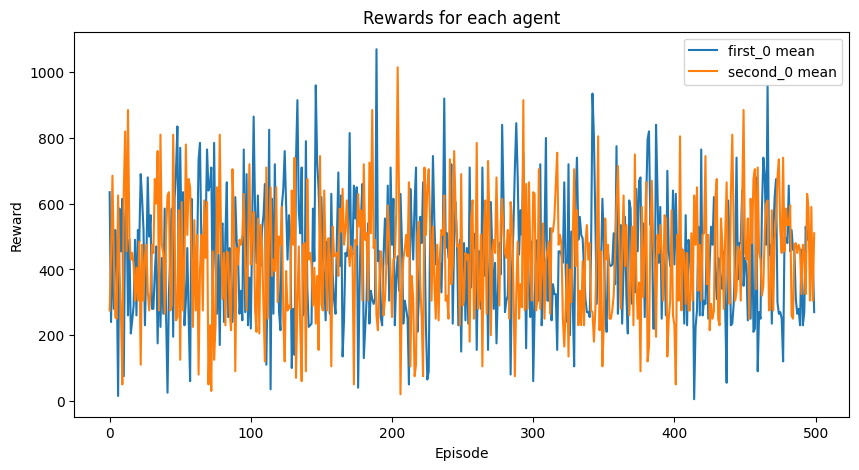

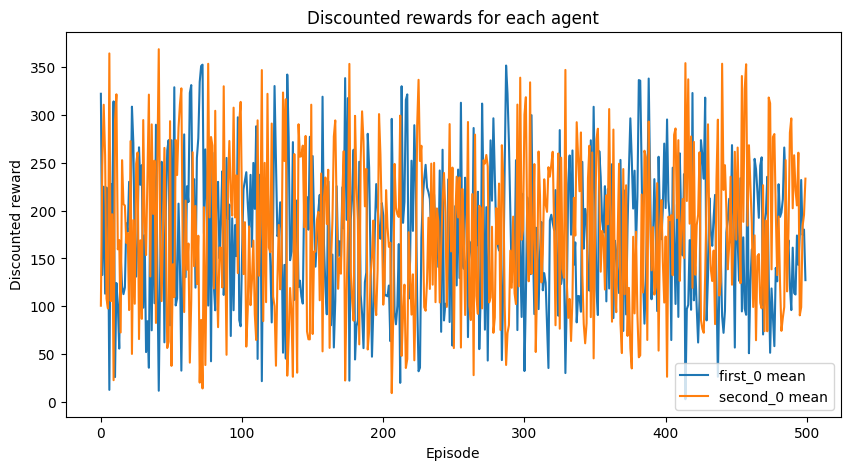

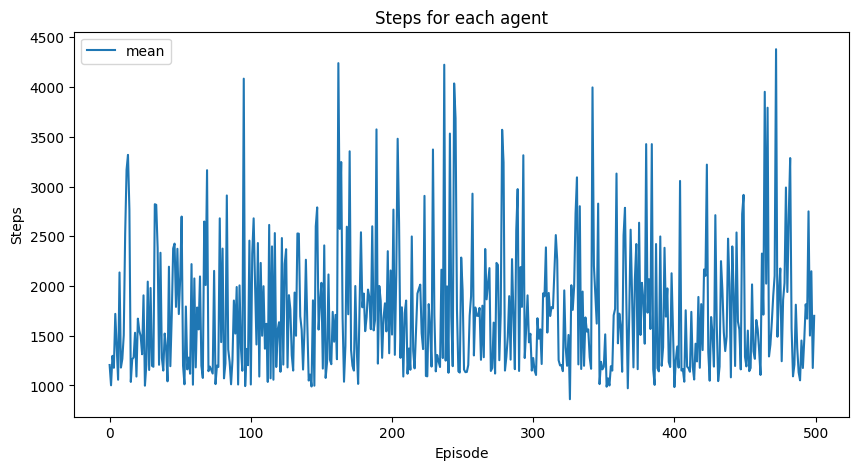

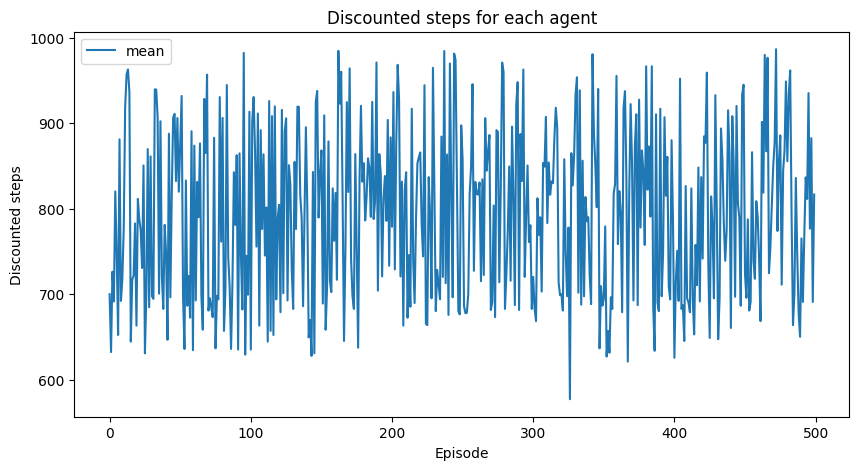

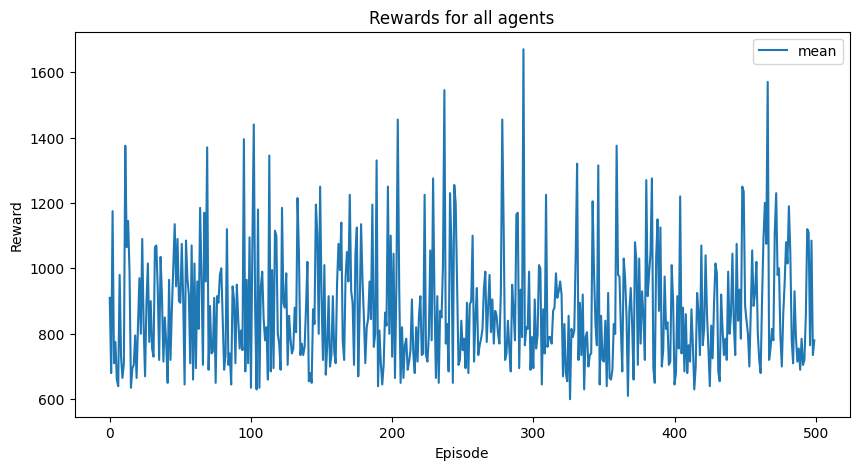

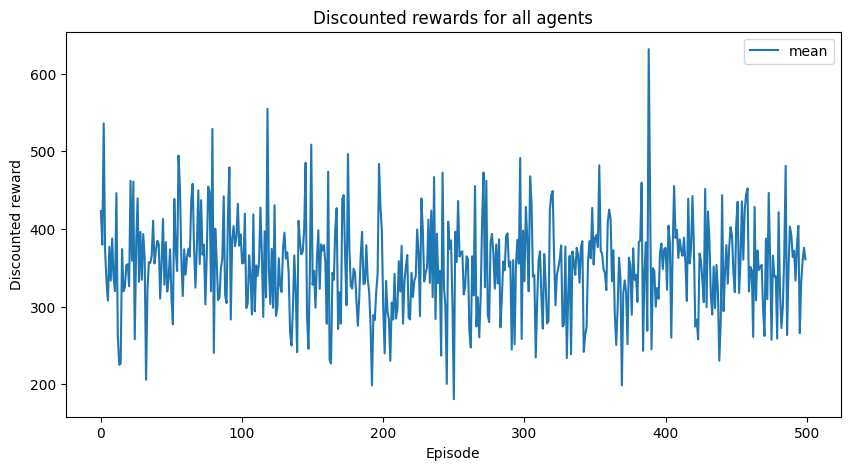

In [255]:
# Calculate the mean and standard deviation of the rewards for each agent and all agents over all experiments
ep_rewards_PPO_mean = {agent: np.mean(ep_rewards_PPO[agent], axis=0) for agent in agent_names}
ep_rewards_PPO_std = {agent: np.std(ep_rewards_PPO[agent], axis=0) for agent in agent_names}
ep_rewards_d_PPO_mean = {agent: np.mean(ep_rewards_d_PPO[agent], axis=0) for agent in agent_names}
ep_rewards_d_PPO_std = {agent: np.std(ep_rewards_d_PPO[agent], axis=0) for agent in agent_names}
ep_steps_PPO_mean = np.mean(ep_steps_PPO, axis=0)
ep_steps_PPO_std = np.std(ep_steps_PPO, axis=0)
ep_steps_d_PPO_mean = np.mean(ep_steps_d_PPO, axis=0)
ep_steps_d_PPO_std = np.std(ep_steps_d_PPO, axis=0)
ep_rewards_all_PPO_mean = np.mean(ep_rewards_all_PPO, axis=0)
ep_rewards_all_PPO_std = np.std(ep_rewards_all_PPO, axis=0)
ep_rewards_d_all_PPO_mean = np.mean(ep_rewards_d_all_PPO, axis=0)
ep_rewards_d_all_PPO_std = np.std(ep_rewards_d_all_PPO, axis=0)

#plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
for agent in agent_names:
    plt.plot(ep_rewards_PPO_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_PPO_mean[agent] - ep_rewards_PPO_std[agent], ep_rewards_PPO_mean[agent] + ep_rewards_PPO_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
for agent in agent_names:
    plt.plot(ep_rewards_d_PPO_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_d_PPO_mean[agent] - ep_rewards_d_PPO_std[agent], ep_rewards_d_PPO_mean[agent] + ep_rewards_d_PPO_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the steps (non-discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.plot(ep_steps_PPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_steps_PPO_mean - ep_steps_PPO_std, ep_steps_PPO_mean + ep_steps_PPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the steps (discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted steps")
plt.plot(ep_steps_d_PPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_steps_d_PPO_mean - ep_steps_d_PPO_std, ep_steps_d_PPO_mean + ep_steps_d_PPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (non-discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ep_rewards_all_PPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_rewards_all_PPO_mean - ep_rewards_all_PPO_std, ep_rewards_all_PPO_mean + ep_rewards_all_PPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.plot(ep_rewards_d_all_PPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_rewards_d_all_PPO_mean - ep_rewards_d_all_PPO_std, ep_rewards_d_all_PPO_mean + ep_rewards_d_all_PPO_std, alpha=0.2)
plt.legend()
plt.show()


### Test the agent from the last experiment

In [256]:
episode_count = 1

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name


env = space_invaders_v2.parallel_env(render_mode="human", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

render_policy_PPO(env, agent_network, episode_count, device, record_video, video_prefix)

env.close()

Model policy has learned to shoot as fast as possible while both going towards the right, not dodging any bullets. It's a greedy policy, and does not take into account of points of betrayal. It's like a single agent playing a two-player game, combining two ships into one.

## MAPPO agent

In [270]:
class MAPPO_Agent(PPO_Agent):
    def __init__(self, num_actions, num_frames, num_agents, effnet=False, pretrained=False):
        super().__init__(num_actions, num_frames, effnet, pretrained)

        #actor and critic networks
        self.actor1 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.actor2 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, num_agents))

    def get_action_and_value(self, x, first_agent, action=None):
        hidden = self.network(x / 133.0)
        if first_agent:
            logits = self.actor1(hidden)
        else:
            logits = self.actor2(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


In [278]:
# function for a training single MAPPO experiment
def train_MAPPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)


    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network.get_action_and_value(obs[0:1], True)
                actions2, logprobs2, _, values2 = agent_network.get_action_and_value(obs[1:2], False)
                #check value should be the same for both agents
                assert np.array_equal(values.cpu().numpy(), values2.cpu().numpy())

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.stack((values[0][0], values2[0][1]), dim=0) #combine values for both agents contribution

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index_even], True, b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network.get_action_and_value(
                        b_obs[batch_index_odd], False, b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value[:,0:1], value2[:,1:2]), dim=0) #obtain the value for each agents

                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index], first_agent, b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    if first_agent:
                        value = value[:,0:1]
                    else:
                        value = value[:,1:2]

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_MAPPO(env, agent_network, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    with torch.no_grad():
        for episode in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                if record_video:
                    frame = parallel_env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            if video_writer is not None:
                video_writer.release()



In [279]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 501

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name


#define arrays to store rewards for each experiment
ep_rewards_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPO = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape
    num_agents = len(env.possible_agents)

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPO[i], ep_steps_d_MAPPO[i], ep_rewards_all_MAPPO[i], ep_rewards_d_all_MAPPO[i] = train_MAPPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPO['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPO['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPO['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPO['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPO_store = np.array([ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPO_store)


Experiment 0
Using device: cuda


  0%|          | 0/501 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/501 [00:36<5:01:09, 36.14s/it]

Training episode 0
Episodic Return: 700.0
Episodic Return Discounted: 340.56168416265086
Episode Length: 1448

Value Loss: 54049.25390625
Policy Loss agent 1: -401.8552551269531
Policy Loss agent 2: -229.32920837402344
Old Approx KL: -0.009062758646905422
Approx KL: 0.0014305285876616836
Clip Fraction: 0.07509157522803261
Explained Variance: -0.003010988235473633

-------------------------------------------



  0%|          | 2/501 [01:17<5:26:04, 39.21s/it]

Training episode 1
Episodic Return: 720.0
Episodic Return Discounted: 285.33580961542157
Episode Length: 1522

Value Loss: 1630.75
Policy Loss agent 1: -20.07948875427246
Policy Loss agent 2: -80.58940124511719
Old Approx KL: -0.017193138599395752
Approx KL: 0.0002046823501586914
Clip Fraction: 0.05078125
Explained Variance: -0.0013370513916015625

-------------------------------------------



  1%|          | 3/501 [01:57<5:26:37, 39.35s/it]

Training episode 2
Episodic Return: 770.0
Episodic Return Discounted: 368.71102610831286
Episode Length: 1352

Value Loss: 4901.6376953125
Policy Loss agent 1: -71.7506332397461
Policy Loss agent 2: 126.59036254882812
Old Approx KL: 0.021673526614904404
Approx KL: 0.0071711670607328415
Clip Fraction: 0.1455182074916129
Explained Variance: -0.0012270212173461914

-------------------------------------------



In [ ]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_MAPPO_store = np.load(path, allow_pickle=True)

ep_rewards_MAPPO = ep_rewards_MAPPO_store[0]
ep_rewards_d_MAPPO = ep_rewards_MAPPO_store[1]
ep_steps_MAPPO = ep_rewards_MAPPO_store[2]
ep_steps_d_MAPPO = ep_rewards_MAPPO_store[3]
ep_rewards_all_MAPPO = ep_rewards_MAPPO_store[4]
ep_rewards_d_all_MAPPO = ep_rewards_MAPPO_store[5]

### Calculations and plotting

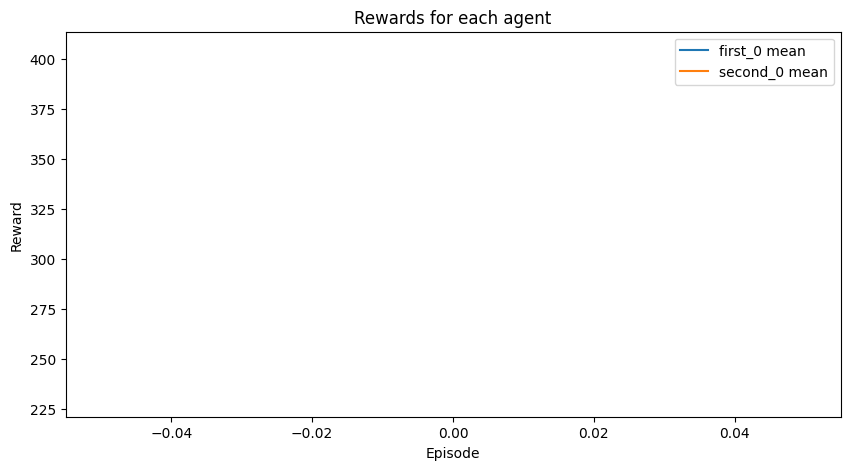

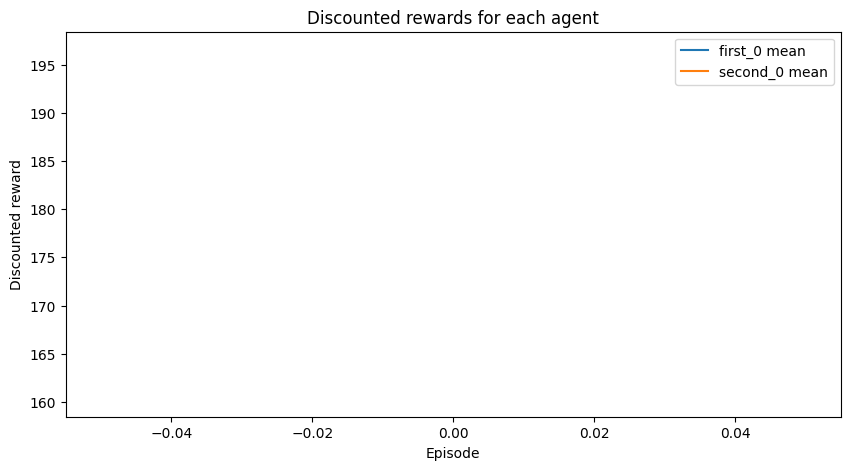

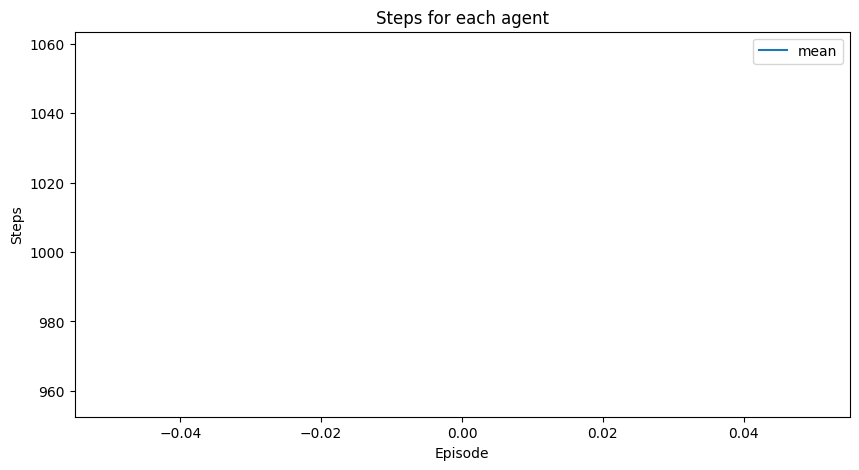

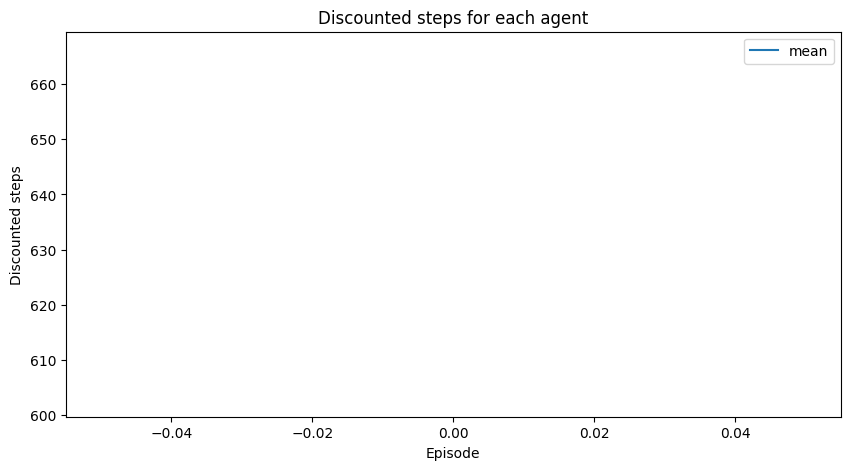

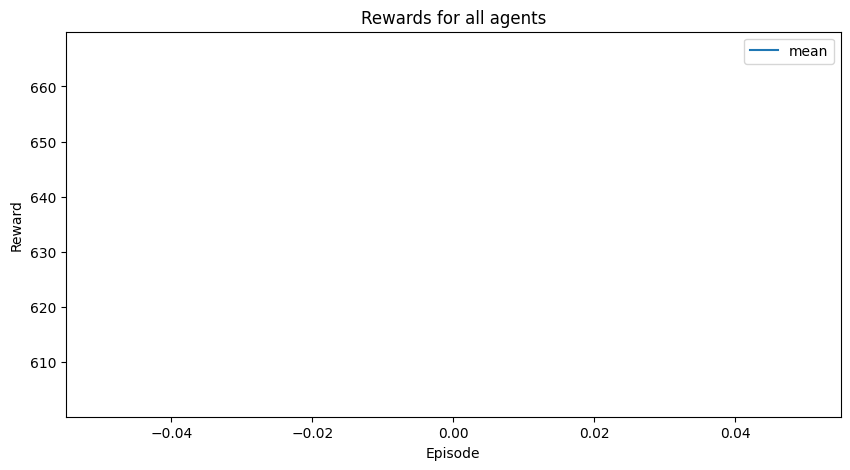

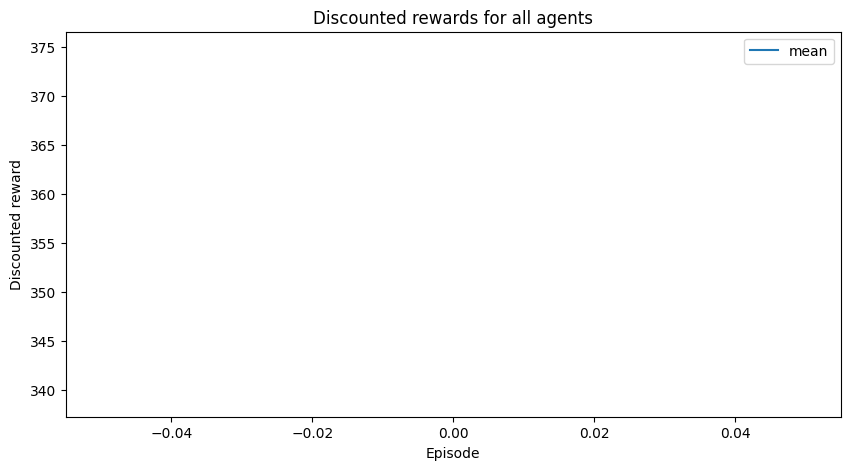

In [ ]:
# Calculate the mean and standard deviation of the rewards for each agent and all agents over all experiments
ep_rewards_MAPPO_mean = {agent: np.mean(ep_rewards_MAPPO[agent], axis=0) for agent in agent_names}
ep_rewards_MAPPO_std = {agent: np.std(ep_rewards_MAPPO[agent], axis=0) for agent in agent_names}
ep_rewards_d_MAPPO_mean = {agent: np.mean(ep_rewards_d_MAPPO[agent], axis=0) for agent in agent_names}
ep_rewards_d_MAPPO_std = {agent: np.std(ep_rewards_d_MAPPO[agent], axis=0) for agent in agent_names}
ep_steps_MAPPO_mean = np.mean(ep_steps_MAPPO, axis=0)
ep_steps_MAPPO_std = np.std(ep_steps_MAPPO, axis=0)
ep_steps_d_MAPPO_mean = np.mean(ep_steps_d_MAPPO, axis=0)
ep_steps_d_MAPPO_std = np.std(ep_steps_d_MAPPO, axis=0)
ep_rewards_all_MAPPO_mean = np.mean(ep_rewards_all_MAPPO, axis=0)
ep_rewards_all_MAPPO_std = np.std(ep_rewards_all_MAPPO, axis=0)
ep_rewards_d_all_MAPPO_mean = np.mean(ep_rewards_d_all_MAPPO, axis=0)
ep_rewards_d_all_MAPPO_std = np.std(ep_rewards_d_all_MAPPO, axis=0)

#plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
for agent in agent_names:
    plt.plot(ep_rewards_MAPPO_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_MAPPO_mean[agent] - ep_rewards_MAPPO_std[agent], ep_rewards_MAPPO_mean[agent] + ep_rewards_MAPPO_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
for agent in agent_names:
    plt.plot(ep_rewards_d_MAPPO_mean[agent], label=f"{agent} mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_d_MAPPO_mean[agent] - ep_rewards_d_MAPPO_std[agent], ep_rewards_d_MAPPO_mean[agent] + ep_rewards_d_MAPPO_std[agent], alpha=0.2)
plt.legend()
plt.show()

#plot the steps (non-discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.plot(ep_steps_MAPPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_steps_MAPPO_mean - ep_steps_MAPPO_std, ep_steps_MAPPO_mean + ep_steps_MAPPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the steps (discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted steps for each agent")
plt.xlabel("Episode")
plt.ylabel("Discounted steps")
plt.plot(ep_steps_d_MAPPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_steps_d_MAPPO_mean - ep_steps_d_MAPPO_std, ep_steps_d_MAPPO_mean + ep_steps_d_MAPPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (non-discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ep_rewards_all_MAPPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_rewards_all_MAPPO_mean - ep_rewards_all_MAPPO_std, ep_rewards_all_MAPPO_mean + ep_rewards_all_MAPPO_std, alpha=0.2)
plt.legend()
plt.show()

#plot the rewards (discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
plt.figure(figsize=(10, 5))
plt.title("Discounted rewards for all agents")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.plot(ep_rewards_d_all_MAPPO_mean, label=f"mean")
plt.fill_between(np.arange(episode_count), ep_rewards_d_all_MAPPO_mean - ep_rewards_d_all_MAPPO_std, ep_rewards_d_all_MAPPO_mean + ep_rewards_d_all_MAPPO_std, alpha=0.2)
plt.legend()
plt.show()



### Test the agent from the last experiment

In [251]:
episode_count = 1

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

env = space_invaders_v2.parallel_env(render_mode="human", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

render_policy_MAPPO(env, agent_network, episode_count, device, record_video, video_prefix)

env.close()